In [40]:
#calcular parâmetros das galáxias
#EM CONSTRUÇÃO!
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from astropy.visualization import LogStretch
from matplotlib.colors import LogNorm
from astropy.modeling import models
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import photutils
import time
import statmorph

def normalize(image):
    m, M = np.min(image), np.max(image)
    return (image-m) / (M-m)

In [41]:
#Imagens
GHII = 'teste455.fits'
image_star = 'teste455_psf.fits'
image_mask = 'flag.fits'
weight = 'weight.fits'

Filename: teste455.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (221, 221)   float32   
[[0.00000000e+00 0.00000000e+00 2.86138803e-03 ... 0.00000000e+00
  0.00000000e+00 9.08478349e-03]
 [0.00000000e+00 1.24474615e-02 8.46236944e-05 ... 0.00000000e+00
  1.99896917e-02 2.49048322e-03]
 [0.00000000e+00 0.00000000e+00 1.80340335e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  4.04013880e-02 5.02732247e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.38825211e-02
  0.00000000e+00 0.00000000e+00]
 [1.78553164e-02 4.15541455e-02 7.30887055e-03 ... 4.20104712e-03
  0.00000000e+00 0.00000000e+00]]
221


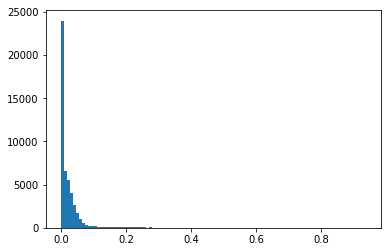

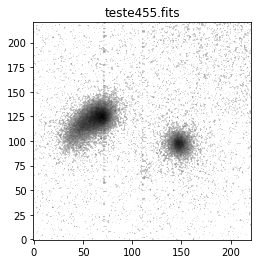

In [42]:
#Galáxia
filename = get_pkg_data_filename(GHII)
fits.info(filename)

galaxy = fits.open(filename)
image_data = galaxy[0].data

NBINS = 100
histogram = plt.hist(image_data.flatten(), NBINS) #histograma usado para saber os limites de pixel

fig = plt.figure()
ax = fig.add_subplot(111)
plt.title(filename)
print(image_data)
print(len(image_data))
plt.imshow(image_data, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.025, vmax=1))

Nível de fundo = 0.010000
Ruído de fundo = 0.014826


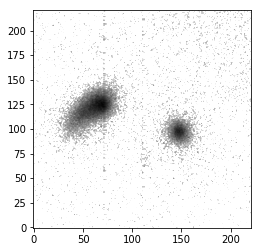

In [43]:
#Ruido de fundo e Nivel de fundo + limpeza da imagem
#mediana da imagem como nível de fundo e o desvio padrão da imagem como ruído de fundo 1-sigma. 
#image median as the background level and the image standard deviation as the 1-sigma background noise
from astropy.stats import mad_std
background_level = np.median(image_data)
print('Nível de fundo = %f'%(background_level))
background_noise = mad_std(image_data)
print('Ruído de fundo = %f'%(background_noise))
image_data-= background_level
plt.imshow(image_data, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.025, vmax=1))
#Sem subtrair o fundo o resultado fica mais parecido com o obtido pelo IRAF.


#image_data.writeto( 'new_'+filename ) #Cria um fits novo já corrigido pelo ruido de fundo

[[ 0.00318465  0.00805727  0.0099864  ...  0.00929046 -0.00111046
  -0.00145137]
 [ 0.05221966  0.00099626 -0.02569547 ... -0.01403782  0.02457979
   0.01944867]
 [-0.00810513 -0.00318924 -0.05016769 ... -0.01662326  0.02777719
   0.02134237]
 ...
 [ 0.00167879  0.01616877 -0.01799586 ... -0.02358329 -0.02684981
  -0.01990187]
 [-0.02529204  0.01104283  0.00425363 ... -0.02600008  0.00571197
   0.01241431]
 [ 0.01415959 -0.01029727 -0.02906135 ... -0.02311102 -0.02014428
  -0.00047448]]
101


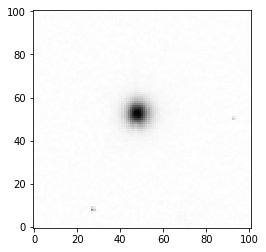

In [44]:
#Estrela PSF
psf = fits.open(image_star)
psf = psf[0].data
plt.imshow(psf, origin='lower', cmap='gray_r')
print(psf) #Matriz estrela
print(len(psf))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
221


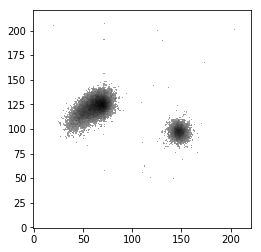

In [45]:
#mapa pixels - weight maps
m_pixel = fits.open(weight)
m_pixel = m_pixel[0].data
plt.imshow(m_pixel, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.025, vmax=1))
print(m_pixel) #Matriz mapa de pixel da galáxia
print(len(m_pixel))

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


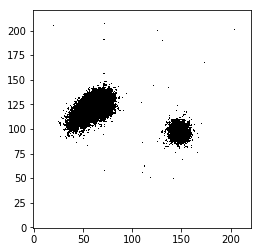

In [46]:
#Imagem mask. Estou usando o flag - TESTE
#A mascara é uma matriz booleana que determina os pixels a serem desconsiderados 
Mask = fits.open(image_mask)
Mask = Mask[0].data
Mask = Mask >= 1  #transforma em matriz booleana
plt.imshow(Mask, origin='lower', cmap='gray')
print(Mask)

In [47]:
#convolução = Matriz de entrada e matriz PSF. Só serve para emular um seeing em uma imagem sintética
#image_data = ndi.convolve(image_data,weights=m_pixel) #usando a origem ,origin=[204,204] da erro
#plt.imshow(image_data, origin='lower', cmap='gray_r',norm=LogNorm(vmin=0.005, vmax=1))

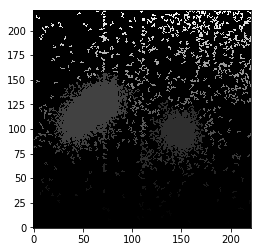

In [48]:
#O SExtractor é indicado para fazer o mapa de segmentação. Segmap
#Porém estou usando photutils para fazer um.
threshold = photutils.detect_threshold(image_data, snr=1.5)
npixels = 5  # minimum number of connected pixels
segm = photutils.detect_sources(image_data, threshold, npixels)
plt.imshow(segm, origin='lower', cmap='gray')

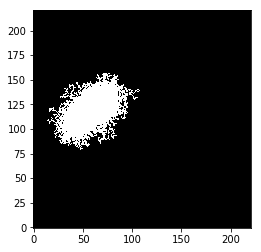

In [49]:
# Keep only the largest segment
label = np.argmax(segm.areas) + 1
segmap = segm.data == label
plt.imshow(segmap, origin='lower', cmap='gray')

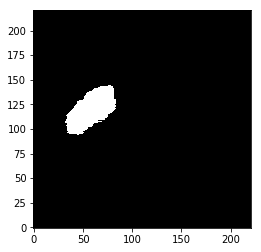

In [50]:
segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
segmap = segmap_float > 0.96
plt.imshow(segmap, origin='lower', cmap='gray')

In [51]:
#Agora que temos todos os dados necessários
#Gain=1000.0 #Assumindo que existe uma média de mil elétrons / pixel no raio efetivo - gain=Gain
m_pixel #Ou Pode ser substituido(Gain) por uma matriz 2D weightmap=m_pixel, fornecida pelo SExtractor
start = time.time()
source_morphs = statmorph.source_morphology(image_data, segmap, weightmap=m_pixel, psf=psf, mask = Mask, eta=0.2)
print('Time: %g s.' % (time.time() - start))

Finished processing source 1.

Time: 1.0628 s.


/home/JackS/anaconda3/lib/python3.7/site-packages/statmorph/statmorph.py:1319: RuntimeWarning: invalid value encountered in true_divide
  snp = np.mean(pixelvals / weightmap[locs])


In [52]:
morph = source_morphs[0]
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r50 =', morph.r50)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)
print('r50 em arcseg =',morph.r50*0.161)
print('Retorna o eixo semi-principal da elipse mínima =',morph.rmax_ellip)
print('O eixo semi-principal de uma abertura elíptica contendo 50% da luz =',morph.rhalf_ellip) 

xc_centroid = 60.776523011003114
yc_centroid = 121.08490909834507
ellipticity_centroid = 0.500879832329634
elongation_centroid = 2.0035255330744923
orientation_centroid = 0.6512394523112982
xc_asymmetry = 65.25000157999213
yc_asymmetry = 124.25000028355905
ellipticity_asymmetry = 0.5402451385880411
elongation_asymmetry = 2.1750721611271002
orientation_asymmetry = 0.6443929453337666
rpetro_circ = 23.98273348499911
rpetro_ellip = 37.40650807101324
rhalf_circ = 11.915165124314738
rhalf_ellip = 17.290971561242742
r20 = 6.356883319149601
r50 = 11.777464332282584
r80 = 19.32198426173663
Gini = 0.48073762092100186
M20 = -1.1591132605209045
F(G, M20) = -0.7770832869000541
S(G, M20) = -0.012186498500613874
sn_per_pixel = -99.0
C = 2.4140374200928436
A = 0.2658270747292367
S = 0.0429172378389019
sersic_amplitude = 0.31308185913482645
sersic_rhalf = 17.290971561242742
sersic_n = 1.0
sersic_xc = 65.25000157999213
sersic_yc = 124.25000028355905
sersic_ellip = 0.5402451385880411
sersic_theta = 0.644

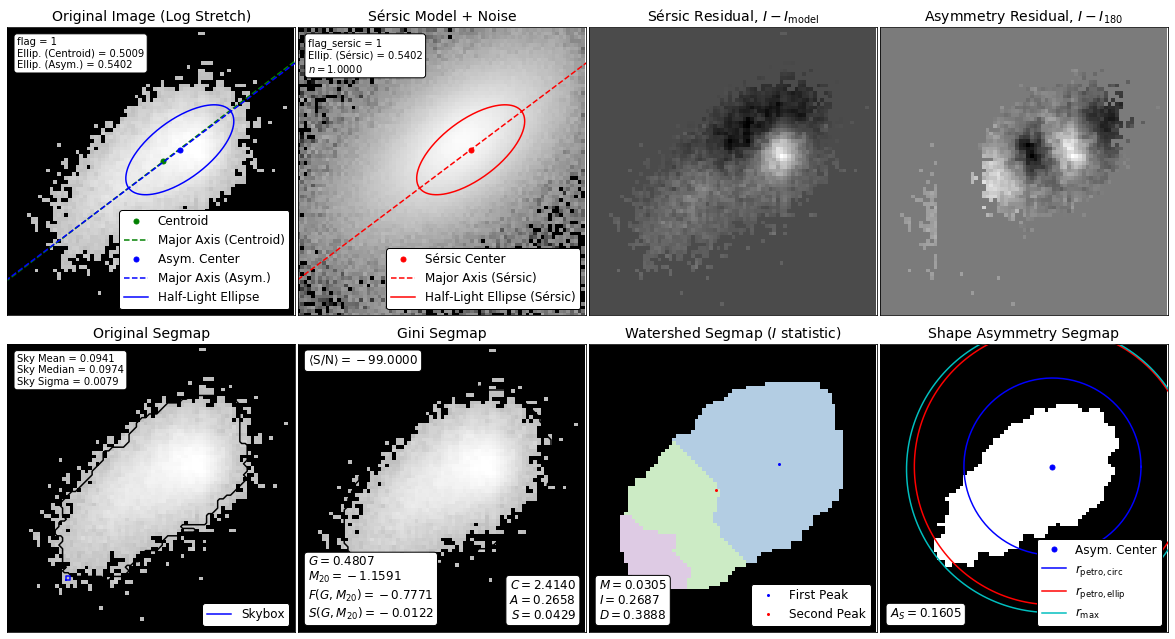

In [53]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)
fig.savefig(GHII+'_morph.png', dpi=150)